In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import sys
import os
sys.path.append(os.path.abspath('..'))

from new_or_used import build_dataset
from utils import get_ordered_columns, extract_id_from_string_list, tune_model, scale_data
from preprocessing import preprocess


import time

# Modelos
from sklearn import ensemble, linear_model, neighbors, svm, tree, discriminant_analysis, neural_network, naive_bayes
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.preprocessing import MinMaxScaler
import random





Directorio base: c:\Users\agu_r\repositorios\new-used-predictor\src
Ruta del dataset: c:\Users\agu_r\repositorios\new-used-predictor\src\..\data\MLA_100k_checked_v3.jsonlines


# Análisis Exploratorio de Datos (EDA)

En esta notebook se realiza un análisis exploratorio del dataset provisto con el objetivo de entender su estructura, calidad, y las principales variables que pueden influir en la predicción del estado de los productos (nuevo o usado). El análisis incluye:

- Inspección de variables clave y su distribución
- Identificación de valores faltantes y datos inconsistentes
- Análisis de correlaciones y relaciones entre variables
- Revisión de campos anidados o estructurados (listas, diccionarios)
- Extracción de primeras hipótesis y features potencialmente útiles

Este EDA servirá como base para la etapa de modelado y selección de features.


## Preprocesado de datos

- Se desglosa la data proveniente en una lista de diccionarios en un dataframe con el que se trabajara.

In [2]:
# ruta del directorio base y del dataset
BASE_DIR = os.getcwd()
print(f" Directorio base: {BASE_DIR}")

DATA_PATH = os.path.abspath(os.path.join(BASE_DIR, "..", "data", "MLA_100k_checked_v3.jsonlines"))
print(f" Ruta del dataset: {DATA_PATH}")

data = [json.loads(x) for x in open(DATA_PATH)]

 Directorio base: c:\Users\agu_r\repositorios\new-used-predictor\src
 Ruta del dataset: c:\Users\agu_r\repositorios\new-used-predictor\data\MLA_100k_checked_v3.jsonlines


In [3]:

# Convertir a DataFrame aplanado
df = pd.json_normalize(data)

# Ordenar columnas
ordered_cols = get_ordered_columns(data)
df = df[[col for col in ordered_cols if col in df.columns]]

# Opcional: reemplazar puntos por guiones bajos
df.columns = [col.replace('.', '_') for col in df.columns]


# Cambio a str el valro de descriptions ya que viene en lista de str
df['descriptions'] = df['descriptions'].apply(extract_id_from_string_list)

In [4]:
df.columns

Index(['seller_address_country_name', 'seller_address_country_id',
       'seller_address_state_name', 'seller_address_state_id',
       'seller_address_city_name', 'seller_address_city_id', 'warranty',
       'sub_status', 'condition', 'deal_ids', 'base_price',
       'shipping_local_pick_up', 'shipping_methods', 'shipping_tags',
       'shipping_free_shipping', 'shipping_mode', 'shipping_dimensions',
       'non_mercado_pago_payment_methods', 'seller_id', 'variations',
       'site_id', 'listing_type_id', 'price', 'attributes', 'buying_mode',
       'tags', 'listing_source', 'parent_item_id', 'coverage_areas',
       'category_id', 'descriptions', 'last_updated',
       'international_delivery_mode', 'pictures', 'id', 'official_store_id',
       'differential_pricing', 'accepts_mercadopago', 'original_price',
       'currency_id', 'thumbnail', 'title', 'automatic_relist', 'date_created',
       'secure_thumbnail', 'stop_time', 'status', 'video_id',
       'catalog_product_id', 'subti

## Analisis de los  atributos 

In [5]:
df.head()

,seller_address_country_name,seller_address_country_id,seller_address_state_name,seller_address_state_id,seller_address_city_name,seller_address_city_id,warranty,sub_status,condition,deal_ids,...,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity
0,Argentina,AR,Capital Federal,AR-C,San Cristóbal,TUxBQlNBTjkwNTZa,None,[],new,[],...,1446669773000,active,None,NaN,None,1,1441485773000,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1
1,Argentina,AR,Capital Federal,AR-C,Buenos Aires,,NUESTRA REPUTACION,[],used,[],...,1448474910000,active,None,NaN,None,1,1443290910000,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1
2,Argentina,AR,Capital Federal,AR-C,Boedo,TUxBQkJPRTQ0OTRa,None,[],used,[],...,1447027027000,active,None,NaN,None,1,1441843027000,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1
3,Argentina,AR,Capital Federal,AR-C,Floresta,TUxBQkZMTzg5MjFa,None,[],new,[],...,1449191596000,active,None,NaN,None,1,1443466076000,http://articulo.mercadolibre.com.ar/MLA9191625...,0,1
4,Argentina,AR,Buenos Aires,AR-B,Tres de febrero,TUxBQ1RSRTMxODE5NA,MI REPUTACION.,[],used,[],...,1445638040000,active,None,NaN,None,1,1440454040000,http://articulo.mercadolibre.com.ar/MLA7787961...,0,1


#### Analizamos la columna condition que es el target

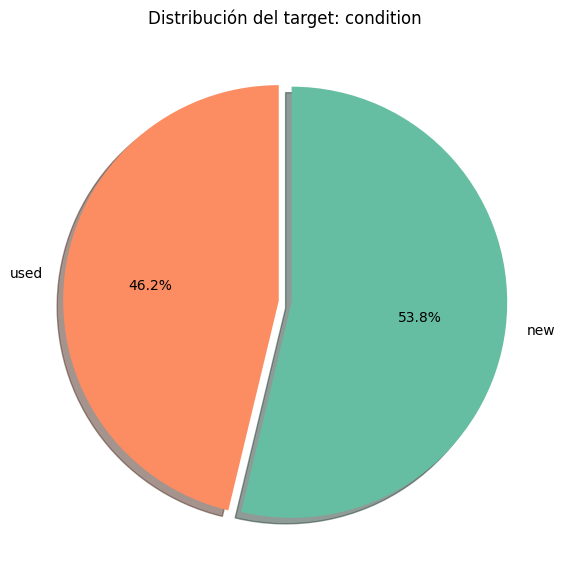

In [6]:


col = 'condition'
counts = df[col].value_counts()

# Colores personalizados (puede ser lista de hex, nombres, etc.)
colors = ["#66bea2", '#fc8d62', '#8da0cb', '#e78ac3']  

# Explode: separa un poco cada porción
explode = [0.03] * len(counts)  # separa todos igual

# Graficar
plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    colors=colors[:len(counts)],
    explode=explode,
    shadow=True
)
plt.title(f'Distribución del target: {col}')
plt.ylabel('')  # Oculta etiqueta del eje Y
plt.show()


El target esta bien balanceado por lo que no seran necesario trabajo en este aspecto


#### Analizamos el resto de columnas

In [7]:
# Observo cantidad de nulos y tipos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 55 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   seller_address_country_name       100000 non-null  object 
 1   seller_address_country_id         100000 non-null  object 
 2   seller_address_state_name         100000 non-null  object 
 3   seller_address_state_id           100000 non-null  object 
 4   seller_address_city_name          100000 non-null  object 
 5   seller_address_city_id            100000 non-null  object 
 6   warranty                          39104 non-null   object 
 7   sub_status                        100000 non-null  object 
 8   condition                         100000 non-null  object 
 9   deal_ids                          100000 non-null  object 
 10  base_price                        100000 non-null  float64
 11  shipping_local_pick_up            100000 non-null  bo

In [8]:
# Evaluo que contienen las columnas que tiene como valor listas 
for col_name in df.columns:
    if df[col_name].apply(lambda x: isinstance(x, list)).any():
        has_non_empty_lists = df[col_name].apply(lambda x: isinstance(x, list) and len(x) > 0).any()
        print(f"¿Hay listas NO vacías en '{col_name}'?: {has_non_empty_lists}")
    else:
        pass


¿Hay listas NO vacías en 'sub_status'?: True
¿Hay listas NO vacías en 'deal_ids'?: True
¿Hay listas NO vacías en 'shipping_methods'?: False
¿Hay listas NO vacías en 'shipping_tags'?: True
¿Hay listas NO vacías en 'non_mercado_pago_payment_methods'?: True
¿Hay listas NO vacías en 'variations'?: True
¿Hay listas NO vacías en 'attributes'?: True
¿Hay listas NO vacías en 'tags'?: True
¿Hay listas NO vacías en 'coverage_areas'?: False
¿Hay listas NO vacías en 'pictures'?: True


In [9]:
print(df[df['variations'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['variations'][6])
print(df[df['attributes'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['attributes'][8])

[{'attribute_combinations': [{'value_id': '92012', 'name': 'Color Primario', 'value_name': 'Azul petróleo', 'id': '83000'}, {'value_id': '82034', 'name': 'Color Secundario', 'value_name': 'Amarillo', 'id': '73001'}, {'value_id': '141996', 'name': 'Talle', 'value_name': '8', 'id': '103000'}], 'seller_custom_field': None, 'picture_ids': ['472901-MLA20442937232_102015', '509801-MLA20442939057_102015', '650901-MLA20442940047_102015', '373901-MLA20442951026_102015', '422901-MLA20442950410_102015'], 'sold_quantity': 0, 'available_quantity': 1, 'id': 9742952789, 'price': 180}]
[{'value_id': '', 'attribute_group_id': 'DFLT', 'name': 'Número de pieza', 'value_name': '37123', 'attribute_group_name': 'Otros', 'id': 'PART_NUMBER'}]


In [10]:
# Evaluo la distribucion de cada variable. No se printea todas debido a la cantidad de datos, voy analizando una por una
df['warranty'].value_counts()

warranty
Sí                                                                                                                                                                5682
Sin garantía                                                                                                                                                      5442
SI                                                                                                                                                                 592
6 meses                                                                                                                                                            547
6 MESES                                                                                                                                                            397
                                                                                                                                                            

### Estudiando atributo por atributo se observa:


- "sub_status" tiene > 80% de listas vacias como valor

- "condition", que es el target, esta balanceado

- "deal_ids" tiene > 80% de listas vacias como valor

- "shipping_methods" contiene todas las entradas con listas vacias o Nan

- "shipping_tags" tiene > 80% de listas vacias como valor

- "shipping_free_shipping" tiene > 95% valor False 

- "non_mercado_pago_payment_methods" contiene como valor listas de diccionarios, en este caso se podria realizar feature de cuantos metodos hay que no sean mp

- "variations" contiene como valor listas de diccionarios. Por lo pronto se podria descartar en un primera iteracion debido a que a priori no contiene informacion "relevante"

- "attributes" contiene como valor listas de diccionarios. Por lo pronto se podria descartar en un primera iteracion debido a que a priori no contiene informacion "relevante"

- "coverage_areas" contiene todas listas vacias como valor

- "listing_source" contiene todas string vacias como valor

- "international_delivery_mode" contiene "none" en todas las entradas

- "pictures" contiene como valor listas de diccionarios, en este caso se podria realizar feature de cuantas pictures hay

- "id" y "descriptions" parecen ser lo mismo pero con mas detalle. El primer valor de description es el id, este es seguido por otro codigo

- "status" tiene > 95% de valor de entrada "active"

- "warranty" contiene ~40% de valores NO nulos. No estan normalizados los valores, se puede hacer un binario de si tiene o no garantia

- "shipping_dimensions"  contiene < 10% de valores NO nulos

- "official_store_id"    contiene < 10% de valores NO nulos

- "differential_pricing" contiene < 10% de valores NO nulos

- "original_price"       contiene < 10% de valores NO nulos

- "video_id"             contiene < 10% de valores NO nulos

- "catalog_product_id"   contiene < 10% de valores NO nulos

- "subtitle"             contiene < 10% de valores NO nulos

#### Estudiamos la correlacion que tengan a priori las columnas numericas con el target. Se lleva a Int las columnas booleanas

In [11]:

df_matriz = df.copy()

# target a binario
df_matriz['condition'] = df_matriz['condition'].map({'new': 1, 'used': 0})


# Convertir a int col booleanas
bool_cols = df_matriz.select_dtypes(include='bool').columns
df_matriz[bool_cols] = df_matriz[bool_cols].astype(int)



numeric_df = df_matriz.select_dtypes(include=['number'])


# Conservo solo columnas con al menos 20% de datos no nulos (hasta 80% de nulos)
numeric_df_clean = numeric_df.dropna(thresh=int(0.2 * len(numeric_df)), axis=1)
corr_matrix = numeric_df_clean.corr()


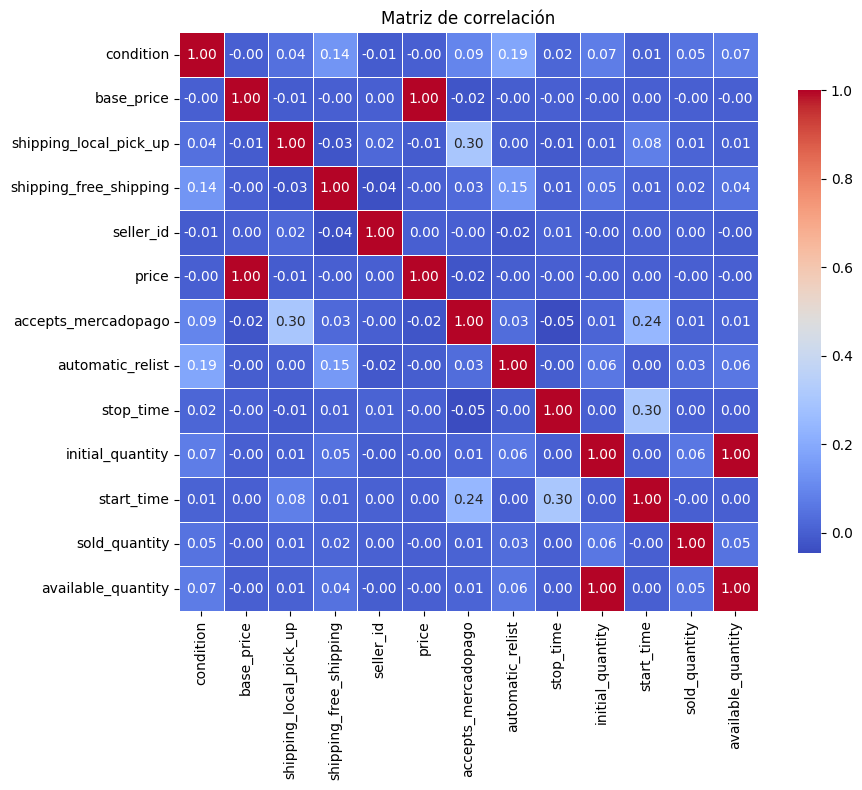

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,         # Muestra los valores
    fmt=".2f",          # Formato con 2 decimales
    cmap="coolwarm",    # Paleta de colores
    square=True,        # Cuadrados proporcionales
    linewidths=0.5,     # Líneas entre celdas
    cbar_kws={"shrink": 0.8}  # Barra lateral más compacta
)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

#### Enlistamos las columnas que mas correlacion tienen con el target. Intuimos estas seran las que mas expliquen la condicion del producto


In [13]:
correlations = numeric_df_clean.corr()['condition'].drop('condition') 
top_corr = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

print('Top de correlaciones con el target:')
print(top_corr.head(10).round(2))


Top de correlaciones con el target:
automatic_relist          0.19
shipping_free_shipping    0.14
accepts_mercadopago       0.09
initial_quantity          0.07
available_quantity        0.07
sold_quantity             0.05
shipping_local_pick_up    0.04
stop_time                 0.02
start_time                0.01
seller_id                -0.01
Name: condition, dtype: float64


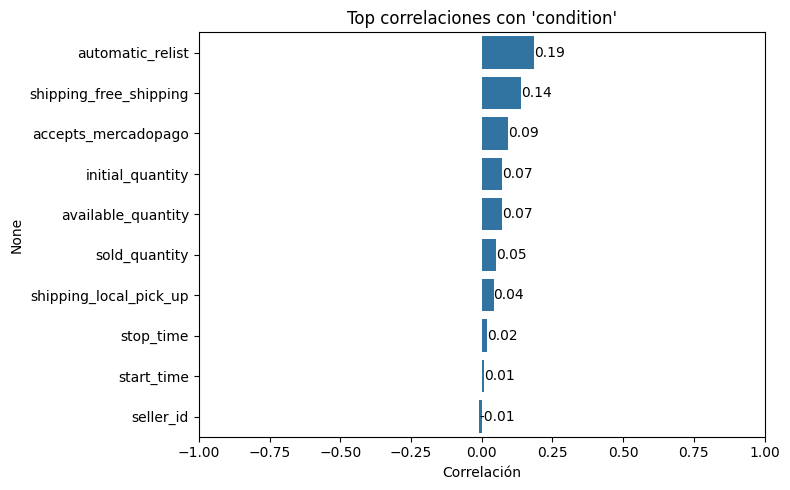

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

top_corr_10 = top_corr.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_corr_10.values, y=top_corr_10.index)
plt.title("Top correlaciones con 'condition'")
plt.xlabel("Correlación")
plt.xlim(-1, 1)

for i, v in enumerate(top_corr_10.values):
    plt.text(v, i, f"{v:.2f}", color='black', va='center')

plt.tight_layout()
plt.show()


#### Observamos la cantidad de valores unicos que contienen las columnas categoricas

In [15]:
import numpy as np

categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    try:
        if df[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any():
            print(f"Columna '{col}' contiene listas o arrays, se omite.")
            continue
        unique_values = df[col].nunique()
        print(f"Columna '{col}' tiene {unique_values} valores únicos.")
    except Exception as e:
        print(f"Error en columna '{col}': {e}")



Columna 'seller_address_country_name' tiene 2 valores únicos.
Columna 'seller_address_country_id' tiene 2 valores únicos.
Columna 'seller_address_state_name' tiene 25 valores únicos.
Columna 'seller_address_state_id' tiene 25 valores únicos.
Columna 'seller_address_city_name' tiene 3656 valores únicos.
Columna 'seller_address_city_id' tiene 295 valores únicos.
Columna 'warranty' tiene 10264 valores únicos.
Columna 'sub_status' contiene listas o arrays, se omite.
Columna 'condition' tiene 2 valores únicos.
Columna 'deal_ids' contiene listas o arrays, se omite.
Columna 'shipping_methods' contiene listas o arrays, se omite.
Columna 'shipping_tags' contiene listas o arrays, se omite.
Columna 'shipping_mode' tiene 4 valores únicos.
Columna 'shipping_dimensions' tiene 13 valores únicos.
Columna 'non_mercado_pago_payment_methods' contiene listas o arrays, se omite.
Columna 'variations' contiene listas o arrays, se omite.
Columna 'site_id' tiene 1 valores únicos.
Columna 'listing_type_id' tien

Se  optara por encodear en valores numericos aquellas columnas categoricas con 30 o menos valores unicos

# Experimentacion de clasificadores

In [16]:
X_train, y_train, X_test, y_test = build_dataset()

In [17]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

# convertir target a binario
y_train = list(map({'new': 1, 'used': 0}.get, y_train))
y_test = list(map({'new': 1, 'used': 0}.get, y_test))

# corroboro no haya nulos en los data frames
print('Hay nulos en X_test? ', X_test.isna().sum().any())
print('Hay nulos en X_train? ', X_train.isna().sum().any())

Columnas  codificadas como 'Nombre_Columna_enc'.
Columnas booleanas codificadas: ['shipping_local_pick_up', 'accepts_mercadopago', 'automatic_relist']
Columnas  codificadas como 'Nombre_Columna_enc'.
Columnas booleanas codificadas: ['shipping_local_pick_up', 'accepts_mercadopago', 'automatic_relist']
Hay nulos en X_test?  False
Hay nulos en X_train?  False


In [18]:
# Selecciono columnas numericas
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_cols_test = X_test.select_dtypes(include=['int64', 'float64']).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols_test]

In [19]:
#Vemos correlación entre variables numéricas para determihar si hay multicolinealidad y quedarnos con las más relevantes.
df_matriz = X_train_numeric.copy()
corr_matrix = df_matriz.corr()

### Visualización de la matriz de correlación

# plt.figure(figsize=(15, 10))
# sns.heatmap(
#     corr_matrix,
#     annot=True,         # Muestra los valores
#     fmt=".1f",          # Formato con 2 decimales
#     cmap="coolwarm",    # Paleta de colores
#     square=True,        # Cuadrados proporcionales
#     linewidths=0.7,     # Líneas entre celdas
#     cbar_kws={"shrink": 0.8}  # Barra lateral más compacta
# )
# plt.title("Matriz de correlación")
# plt.tight_layout()
# plt.show()

In [20]:
df_matriz = X_train[numeric_cols].copy()
correlations = df_matriz.corr()['condition_enc'].drop('condition_enc') 
top_corr = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

print('Top de correlaciones con el target:')
print(top_corr.head(10).round(2))


# Crear nuevo DataFrame solo con columnas con cierto umbral de correlación
# mask = abs(top_corr) > 0.015
mask = top_corr.abs() > 0
top_features = top_corr[mask].index.tolist()
X_train_top = X_train_numeric[top_features]
X_test_top = X_test_numeric[top_features]

Top de correlaciones con el target:
automatic_relist_enc       0.19
listing_type_id_enc        0.14
is_free_shipping           0.14
has_warranty               0.13
has_nuevo_in_title         0.12
non_mp_methods_count       0.11
title_word_count           0.10
shipping_mode_enc         -0.10
accepts_mercadopago_enc    0.09
initial_quantity           0.07
Name: condition_enc, dtype: float64


In [21]:
# Quito columna target antes de entrenar 
X_train_numeric = X_train_numeric.drop(columns=['condition_enc'], errors='ignore')

# verifico que efectivamnete no este target ni en train ni test
print('Hay columna condition en X_train_numeric?', 'condition_enc' in X_train_numeric.columns)
print('Hay columna condition en X_test_numeric?', 'condition_enc' in X_test_numeric.columns)
print('Hay columna condition en X_train_top?', 'condition_enc' in X_train_top.columns)
print('Hay columna condition en X_test_top?', 'condition_enc' in X_test_top.columns)

print('Columnas utilizadas para entrenar:')
print(X_train_top.columns)

Hay columna condition en X_train_numeric? False
Hay columna condition en X_test_numeric? False
Hay columna condition en X_train_top? False
Hay columna condition en X_test_top? False
Columnas utilizadas para entrenar:
Index(['automatic_relist_enc', 'listing_type_id_enc', 'is_free_shipping',
       'has_warranty', 'has_nuevo_in_title', 'non_mp_methods_count',
       'title_word_count', 'shipping_mode_enc', 'accepts_mercadopago_enc',
       'initial_quantity', 'sold_quantity', 'is_active', 'buying_mode_enc',
       'pictures_count', 'shipping_local_pick_up_enc', 'has_original_price',
       'seller_address_state_id_enc', 'currency_id_enc', 'stop_time',
       'start_time', 'seller_address_state_name_enc', 'seller_id',
       'seller_address_country_name_enc', 'price'],
      dtype='object')


In [22]:
## Escaleo los datos

scaler = MinMaxScaler()
X_train_top = scaler.fit_transform(X_train_top)
X_test_top = scaler.transform(X_test_top)

In [23]:
# Lista de modelos


MLA = [
    ## Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    ensemble.HistGradientBoostingClassifier(),

    ## Boosting externos
    XGBClassifier(),
    LGBMClassifier(),
    CatBoostClassifier(verbose=0),

    ## GLM
    # linear_model.LogisticRegression(max_iter=1000),
    # linear_model.LogisticRegressionCV(max_iter=1000),
    # linear_model.RidgeClassifier(),
    # linear_model.SGDClassifier(),

    # ## Nearest Neighbor
    # neighbors.KNeighborsClassifier(),
    # neighbors.RadiusNeighborsClassifier(radius=5.0),

    ## SVM
    # svm.SVC(),
    # svm.LinearSVC(max_iter=10000),
    # svm.NuSVC(),

    ## Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # ## Discriminant Analysis
    # discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),

    # ## Naive Bayes
    # naive_bayes.GaussianNB(),
    # naive_bayes.MultinomialNB(),
    # naive_bayes.BernoulliNB(),
    naive_bayes.ComplementNB(),

    ## Neural Network (shallow MLP)
    # neural_network.MLPClassifier(
    #     hidden_layer_sizes=(100,),
    #     activation='relu',
    #     solver='adam',
    #     max_iter=300,
    #     random_state=42
    # )
]


# Tabla de comparación
MLA_columns = [
    'MLA Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1 Score',
    'Tasa de mala clasificacion',
    'Tiempo'
]
MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predict = pd.DataFrame()
MLA_test = pd.DataFrame()

# Loop de entrenamiento y evaluación
row_index = 0
for alg in MLA:
    inicio = time.time()
    
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name

    alg.fit(X_train_top, y_train)
    y_pred = alg.predict(X_test_top)

    # Métricas
    MLA_compare.loc[row_index, 'Accuracy'] = round(accuracy_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'F1 Score'] = round(f1_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'Tasa de mala clasificacion'] = round(1 - accuracy_score(y_test, y_pred), 3)

    fin = time.time()
    MLA_compare.loc[row_index, 'Tiempo'] = round(fin - inicio, 2)

    # Predicciones para análisis
    MLA_predict[MLA_name] = alg.predict(X_train_top)
    MLA_test[MLA_name] = y_pred

    row_index += 1

# Ordenar por precisión
MLA_compare.sort_values(by='Accuracy', ascending=False, inplace=True)




[LightGBM] [Info] Number of positive: 48352, number of negative: 41648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1604
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537244 -> initscore=0.149254
[LightGBM] [Info] Start training from score 0.149254


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [24]:
MLA_compare

,MLA Name,Accuracy,Precision,Recall,F1 Score,Tasa de mala clasificacion,Tiempo
4,RandomForestClassifier,0.876,0.903,0.864,0.883,0.124,10.9
8,CatBoostClassifier,0.874,0.899,0.864,0.881,0.126,17.31
6,XGBClassifier,0.871,0.895,0.863,0.878,0.129,0.44
7,LGBMClassifier,0.867,0.894,0.854,0.874,0.133,0.62
2,ExtraTreesClassifier,0.866,0.88,0.872,0.876,0.134,9.4
5,HistGradientBoostingClassifier,0.864,0.893,0.851,0.871,0.136,4.67
1,BaggingClassifier,0.858,0.899,0.831,0.863,0.142,5.09
3,GradientBoostingClassifier,0.848,0.872,0.843,0.857,0.152,14.36
0,AdaBoostClassifier,0.828,0.827,0.864,0.845,0.172,3.15
9,DecisionTreeClassifier,0.82,0.838,0.826,0.832,0.18,0.84


### Experimentamos variando las columnas utilizadas 

In [25]:

# Todas las columnas numéricas posibles (excluí el target si está presente)
all_columns = X_train_numeric.columns.tolist()
if 'condition_enc' in all_columns:
    all_columns.remove('condition_enc')

resultados = []

# Número de experimentos
n_experimentos = 5
columnas_por_prueba = 20 
# Lista de columnas a probar
lista_cant_col = [ 20, 23]   
# lista_cant_col = [24,20]   

j = 0

for i in range(n_experimentos):
    for cant_col in lista_cant_col:
        j += 1
        # Selección aleatoria de columnas
        if cant_col > len(all_columns):
            raise ValueError(f"⚠️ Estás pidiendo {cant_col} columnas, pero solo hay {len(all_columns)} disponibles.")
        columnas_random = random.sample(all_columns, cant_col)

        # Subset de datos
        X_train_sel = X_train_numeric[columnas_random]
        X_test_sel = X_test_numeric[columnas_random]

        X_train_sel, X_test_sel = scale_data(X_train_sel, X_test_sel)

        # Modelo
        model = XGBClassifier(
                n_estimators=900,
                max_depth=12,
                learning_rate=0.05,
                subsample=0.85,
                colsample_bytree=0.7,
                min_child_weight=1,
                gamma=0,
                scale_pos_weight=1,
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=42
        )
     

        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_test_sel)

        # Métricas
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        resultados.append({
            "exp": j,
            "columns": columnas_random,
            "cant_cols": cant_col,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1
        })
        # Imprimir progreso
        print(f"Experimento {j}: {cant_col} columnas seleccionadas - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

# Mostrar resultados ordenados 
df_resultados = pd.DataFrame(resultados).sort_values(by="accuracy", ascending=False)
print("\nResultados de los experimentos:")
print(df_resultados[["exp", "accuracy", "precision", "recall", "f1_score"]])


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:46:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Experimento 1: 20 columnas seleccionadas - Accuracy: 0.8776, Precision: 0.8969, Recall: 0.8740, F1 Score: 0.8853


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:46:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Experimento 2: 23 columnas seleccionadas - Accuracy: 0.8856, Precision: 0.9034, Recall: 0.8827, F1 Score: 0.8930


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:46:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Experimento 3: 20 columnas seleccionadas - Accuracy: 0.8341, Precision: 0.8754, Recall: 0.8082, F1 Score: 0.8404


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:46:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Experimento 4: 23 columnas seleccionadas - Accuracy: 0.8859, Precision: 0.9049, Recall: 0.8816, F1 Score: 0.8931


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:46:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Experimento 5: 20 columnas seleccionadas - Accuracy: 0.8416, Precision: 0.8831, Recall: 0.8148, F1 Score: 0.8476


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:47:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Experimento 6: 23 columnas seleccionadas - Accuracy: 0.8841, Precision: 0.9035, Recall: 0.8796, F1 Score: 0.8914


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:47:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Experimento 7: 20 columnas seleccionadas - Accuracy: 0.8221, Precision: 0.8530, Recall: 0.8106, F1 Score: 0.8313


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:47:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Experimento 8: 23 columnas seleccionadas - Accuracy: 0.8794, Precision: 0.8976, Recall: 0.8770, F1 Score: 0.8872


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:47:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Experimento 9: 20 columnas seleccionadas - Accuracy: 0.8817, Precision: 0.8988, Recall: 0.8803, F1 Score: 0.8894


c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:47:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Experimento 10: 23 columnas seleccionadas - Accuracy: 0.8820, Precision: 0.9003, Recall: 0.8790, F1 Score: 0.8896

Resultados de los experimentos:
   exp  accuracy  precision    recall  f1_score
3    4    0.8859   0.904879  0.881613  0.893095
1    2    0.8856   0.903446  0.882723  0.892964
5    6    0.8841   0.903477  0.879578  0.891368
9   10    0.8820   0.900341  0.879023  0.889554
8    9    0.8817   0.898772  0.880318  0.889450
7    8    0.8794   0.897577  0.876989  0.887163
0    1    0.8776   0.896925  0.874029  0.885329
4    5    0.8416   0.883119  0.814835  0.847604
2    3    0.8341   0.875376  0.808176  0.840435
6    7    0.8221   0.853027  0.810581  0.831262


Mejor resultados con las siguientes columnas:

['start_time',
  'non_mp_methods_count',
  'is_active',
  'currency_id_enc',
  'has_warranty',
  'shipping_mode_enc',
  'listing_type_id_enc',
  'price',
  'buying_mode_enc',
  'automatic_relist_enc',
  'has_original_price',
  'pictures_count',
  'seller_address_state_name_enc',
  'sold_quantity',
  'stop_time',
  'seller_id',
  'has_nuevo_in_title',
  'initial_quantity']


### Ajustamos hiperparametros

In [26]:
# Ajustar parámetros del XGBoost

# ratio de clases
neg = np.sum(np.array(y_train) == 0)
pos = np.sum(np.array(y_train) == 1)
scale_ratio = pos / neg

param_dist = {
    'n_estimators': [900, 1100, 1300],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [8, 10, 12],
    'min_child_weight': [1, 2, 4],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.3],
    'reg_lambda': [1, 3, 5],
    'scale_pos_weight': [1, scale_ratio]
}

col_a_utilizar = ['start_time',
  'non_mp_methods_count',
  'is_active',
  'currency_id_enc',
  'has_warranty',
  'shipping_mode_enc',
  'listing_type_id_enc',
  'price',
  'buying_mode_enc',
  'automatic_relist_enc',
  'has_original_price',
  'pictures_count',
  'seller_address_state_name_enc',
  'sold_quantity',
  'stop_time',
  'seller_id',
  'has_nuevo_in_title',
  'initial_quantity']



X_train_sel = X_train_numeric[col_a_utilizar]
X_test_sel = X_test_numeric[col_a_utilizar]

X_train_sel, X_test_sel = scale_data(X_train_sel, X_test_sel)


best_xgb = tune_model("xgboost", X_train_sel, y_train, param_dist, n_iter=2, cv=2) # se realizo una busqueda de 200 iteraciones y 2 cv


Fitting 2 folds for each of 2 candidates, totalling 4 fits

 Mejor score (xgboost): 0.8696
📌 Mejores parámetros: {'subsample': 0.7, 'scale_pos_weight': np.float64(1.1609681137149443), 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 1100, 'min_child_weight': 2, 'max_depth': 12, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}


In [27]:
# Ajustar parámetros del Random Forest


param_dist = {
    'n_estimators': [200, 500, 700, 800, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

col_a_utilizar = ['start_time',
  'non_mp_methods_count',
  'is_active',
  'currency_id_enc',
  'has_warranty',
  'shipping_mode_enc',
  'listing_type_id_enc',
  'price',
  'buying_mode_enc',
  'automatic_relist_enc',
  'has_original_price',
  'pictures_count',
  'seller_address_state_name_enc',
  'sold_quantity',
  'stop_time',
  'seller_id',
  'has_nuevo_in_title',
  'initial_quantity']


X_train_sel = X_train_numeric[col_a_utilizar]
X_test_sel = X_test_numeric[col_a_utilizar]

X_train_sel, X_test_sel = scale_data(X_train_sel, X_test_sel)

# best_rf = tune_model("random_forest", X_train_sel, y_train, n_iter=30, cv=5)

In [28]:
# defino el modelo ganador
best_model = best_xgb  
# Entreno el modelo ganador con todo el conjunto de entrenamiento
best_model.fit(X_train_top, y_train)
# Predicciones finales
y_pred_final = best_model.predict(X_test_top)
# Evaluación final
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"✅ Precisión final del modelo ganador: {final_accuracy:.4f}")


✅ Precisión final del modelo ganador: 0.8826


#### Pruebas libres sobre el mejor Modelo encontrado

In [29]:

neg = np.sum(np.array(y_train) == 0)
pos = np.sum(np.array(y_train) == 1)
scale_ratio = neg / pos

print(f"🧮 Ratio calculado: {scale_ratio:.2f}")

🧮 Ratio calculado: 0.86


In [30]:
model = XGBClassifier(
        n_estimators=900,
        max_depth=12,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.7,
        min_child_weight=1,
        gamma=0,
        scale_pos_weight=1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
)
# model = XGBClassifier(
#         subsample= 0.9,
#         scale_pos_weight= 1,
#         reg_lambda= 1,
#         reg_alpha= 0,
#         n_estimators= 1100,
#         min_child_weight= 1,
#         max_depth= 10,
#         learning_rate= 0.03,
#         gamma= 0.5,
#         colsample_bytree= 0.6)



col_a_utilizar = ['start_time',
  'non_mp_methods_count',
  'is_active',
  'currency_id_enc',
  'has_warranty',
  'shipping_mode_enc',
  'listing_type_id_enc',
  'price',
  'buying_mode_enc',
  'automatic_relist_enc',
  'has_original_price',
  'pictures_count',
  'seller_address_state_name_enc',
  'sold_quantity',
  'stop_time',
  'seller_id',
  'has_nuevo_in_title',
  'initial_quantity']

# col_a_utilizar = ['has_nuevo_in_title',
#   'is_free_shipping',
#   'sold_quantity',
#   'initial_quantity',
#   'listing_type_id_enc',
#   'pictures_count',
#   'seller_address_country_name_enc',
#   'start_time',
#   'non_mp_methods_count',
#   'automatic_relist_enc',
#   'buying_mode_enc',
#   'seller_address_state_name_enc',
#   'price',
#   'has_warranty',
#   'seller_id',
#   'shipping_mode_enc',
#   'is_active',
#   'accepts_mercadopago_enc',
#   'title_word_count',
#   'has_original_price']


X_train_sel = X_train_numeric[col_a_utilizar]
X_test_sel = X_test_numeric[col_a_utilizar]


X_train_sel, X_test_sel = scale_data(X_train_sel, X_test_sel)


model.fit(X_train_sel, y_train)
# Predicciones finales
y_pred_final = model.predict(X_test_sel)
# Evaluación final
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
print(f"✅ Accuracy final del modelo ganador: {final_accuracy:.4f}")
print(f"✅ Precisión final del modelo ganador: {final_precision:.4f}")

c:\Users\agu_r\repositorios\env_meli\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:48:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy final del modelo ganador: 0.8887
✅ Precisión final del modelo ganador: 0.9058


Vemos la matriz de confusion del modelo.

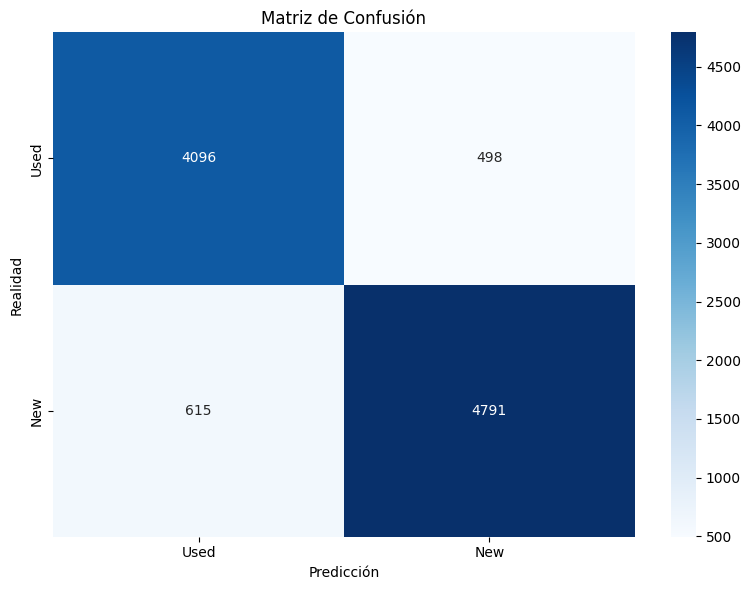

In [31]:
#plot matrix de confusión

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Used', 'New'], yticklabels=['Used', 'New'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.tight_layout()
plt.show()
